# Notebook 9: Using Random Forests to classify phases in the Ising Model



## Learning Goal

The goal of this notebook is to show how one can employ ensemble methods such as Random Forests to classify the states of the 2D Ising model according to their phases. We discuss concepts like decision trees, extreme decision trees, and out-of-bag error. The notebook also introduces the powerful scikit-learn `Ensemble` class.


## Setting up the problem

The Hamiltonian for the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.

We will use the same basic idea as we did for logistic regression. An interesting question to ask is whether one can train a statistical model to distinguish between the two phases of the Ising model. In other words, given an Ising state, we would like to classify whether it belongs to the ordered or the disordered phase, without any additional information other than the spin configuration itself. This categorical machine learning problem is well suited for ensemble methods and in particular Random Forests.

To this end, we consider the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo (MC) sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set. Using Onsager's criterion, we can assign a label to each state according to its phase: $0$ if the state is disordered, and $1$ if it is ordered. 

It is well-known that, near the critical temperature $T_c$, the ferromagnetic correlation length diverges which, among others, leads to a critical slowing down of the MC algorithm. Therefore, we expect identifying the phases to be harder in the critical region. With this in mind, consider the following three types of states: ordered ($T/J<2.0$), critical ($2.0\leq T/J\leq 2.5)$ and disordered ($T/J>2.5$). We use both ordered and disordered states to train the random forest and, once the supervised training procedure is complete, we shall evaluate the performance of our classifier on unseen ordered, disordered and critical states. 

A link to the Ising dataset can be found at [https://physics.bu.edu/~pankajm/MLnotebooks.html](https://physics.bu.edu/~pankajm/MLnotebooks.html).

In [1]:
import numpy as np

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=40 # linear system size
J=-1.0 # Ising interaction
T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

In [4]:
##### prepare training and test data sets

import pickle,os
from sklearn.model_selection import train_test_split

###### define ML parameters
train_to_test_ratio=0.8 # training samples

# path to data directory
path_to_data=os.path.expanduser('~')+'/Dropbox/MachineLearningReview/Datasets/isingMC/'

# load data
file_name = "Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
data = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
labels = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)


# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

/Users/mbukov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


X_train shape: (104000, 1600)
Y_train shape: (104000,)

104000 train samples
30000 critical samples
26000 test samples


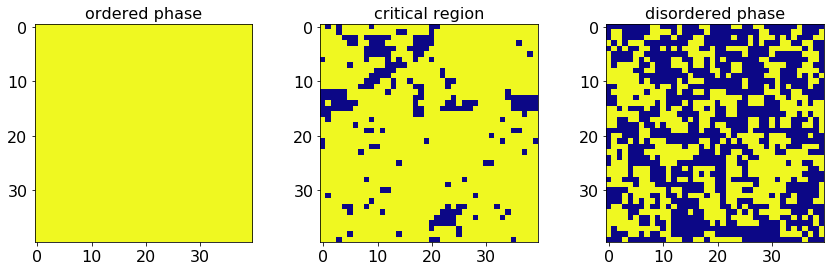

In [5]:
##### plot a few Ising states
%matplotlib inline 

#import ml_style as style
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams.update(style.style)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L,L),**cmap_args)
#axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[10001].reshape(L,L),**cmap_args)
#axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
#axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

## Random Forests

** Hyperparameters**

We start by training with Random Forests. As discussed in Sec. VIII of the review, Random Forests are ensemble models. Here we will use the sci-kit learn implementation of random forests.  There are two main hyper-parameters that will be important in practice for the performance of the algorithm: the number of estimators in the ensemble and the depth of the trees used. The former is controlled by the parameter `n_estimators` whereas the latter (the complexity of the trees used) can be controlled in many distinct ways (`min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc). For our simple dataset, it does not really make much difference which one of these we use. We will just use the `min_samples_split` parameter that dictates how many samples need to be in each node of the classification tree. The bigger this number, the more coarse our trees and data partitioning.

In the code below, we will just consider extremely fine trees (`min_samples_split=2`) or extremely coarse trees (`min_samples_split=10000`). As we will see, both of these tree complexities are sufficient to distinguish the ordered from the disordered samples. The reason is clear from the pictures above: this is extremely easy. However, if we want to train deep in these simple phases, and then use our algorithm to distinguish critical samples it is crucial we use more complex trees even though the performance on the disordered and ordered phases is indistinguishable for coarse and complex trees.

**Out of Bag (OOB) Estimates**

For more complicated datasets, how can we choose the right hyperparameters? We can actually make use of one of the most important and interesting features of ensemble methods that employ Bagging: out-of-bag (OOB) estimates. Whenever we bag data, since we are drawing samples with replacement, we can ask how well our classifiers do on data points that are *not used* in the training. This is the out-of-bag prediction error and plays a similar role to cross-validation error in other ML methods. Since this is the best proxy for out-of-sample prediction, we choose hyperparameters to minimize the out-of-bag error.

In [6]:
# Apply Random Forest

#This is the random forest classifier
from sklearn.ensemble import RandomForestClassifier

#This is the extreme randomized trees
from sklearn.ensemble import ExtraTreesClassifier



#import time to see how perforamance depends on run time

import timeit

import warnings
#Comment to turn on warnings
warnings.filterwarnings("ignore")

#We will check 



min_estimators = 10
max_estimators = 101
n_estimators=np.arange(min_estimators, max_estimators, 10)
leaf_sizes=[2,10000]
n=len(n_estimators)
m=len(leaf_sizes)

#Allocate Arrays for various quantities

RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
RFC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i in range(0,n):
    for j in range(0,m):
        
        print('n_estimators: '+str(n_estimators[i])+', leaf_size: '+str(leaf_sizes[j]))
        
        start_time = timeit.default_timer()
        RFC = RandomForestClassifier(n_estimators=n_estimators[i], max_depth=None,min_samples_split=leaf_sizes[j],oob_score=True, random_state=0)
        RFC.fit(X_train, Y_train)
        run_time[i,j] = timeit.default_timer() - start_time

    
    # check accuracy
        RFC_train_accuracy[i,j]=RFC.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=RFC.oob_score_
        RFC_test_accuracy[i,j]=RFC.score(X_test,Y_test)
        RFC_critical_accuracy[i,j]=RFC.score(X_critical,Y_critical)
        if print_flag:
            print('accuracy:time, train, OOB estimate,test, critical')
            print('liblin: %0.4f, %0.4f, %0.4f,  %0.4f, %0.4f \n' %(run_time[i,j],RFC_train_accuracy[i,j],RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j]))





n_estimators: 10, leaf_size: 2
accuracy:time, train, OOB estimate,test, critical
liblin: 22.8288, 1.0000, 0.9931,  0.9999, 0.8041 

n_estimators: 10, leaf_size: 10000
accuracy:time, train, OOB estimate,test, critical
liblin: 15.9262, 0.9992, 0.9894,  0.9992, 0.6803 

n_estimators: 20, leaf_size: 2
accuracy:time, train, OOB estimate,test, critical
liblin: 36.9083, 1.0000, 0.9998,  1.0000, 0.8186 

n_estimators: 20, leaf_size: 10000
accuracy:time, train, OOB estimate,test, critical
liblin: 28.2213, 0.9993, 0.9982,  0.9993, 0.6852 

n_estimators: 30, leaf_size: 2
accuracy:time, train, OOB estimate,test, critical
liblin: 53.6608, 1.0000, 1.0000,  1.0000, 0.8244 

n_estimators: 30, leaf_size: 10000
accuracy:time, train, OOB estimate,test, critical
liblin: 51.0709, 0.9993, 0.9990,  0.9993, 0.6854 

n_estimators: 40, leaf_size: 2
accuracy:time, train, OOB estimate,test, critical
liblin: 70.3218, 1.0000, 1.0000,  1.0000, 0.8278 

n_estimators: 40, leaf_size: 10000
accuracy:time, train, OOB est

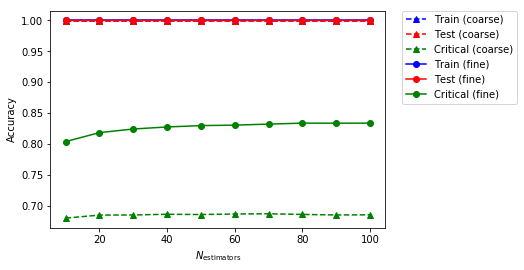

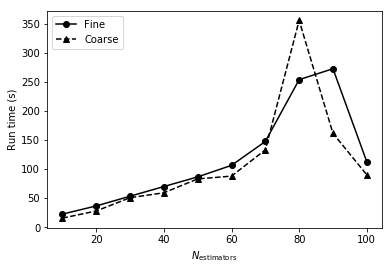

In [9]:
plt.figure()
plt.plot(n_estimators,RFC_train_accuracy[:,1],'--b^',label='Train (coarse)')
plt.plot(n_estimators,RFC_test_accuracy[:,1],'--r^',label='Test (coarse)')
plt.plot(n_estimators,RFC_critical_accuracy[:,1],'--g^',label='Critical (coarse)')

plt.plot(n_estimators,RFC_train_accuracy[:,0],'o-b',label='Train (fine)')
plt.plot(n_estimators,RFC_test_accuracy[:,0],'o-r',label='Test (fine)')
plt.plot(n_estimators,RFC_critical_accuracy[:,0],'o-g',label='Critical (fine)')

#plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Ising_RF.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(n_estimators, run_time[:,0], 'o-k',label='Fine')
plt.plot(n_estimators, run_time[:,1], '--k^',label='Coarse')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')


plt.legend(loc=2)
#plt.savefig("Ising_RF_Runtime.pdf")

plt.show()

## Extremely Randomized Trees##

As discussed in the main text, the effectiveness of ensemble methods generally increases as the correlations between members of the ensemble decrease. This idea has been leveraged to make methods that introduce even more randomness into the ensemble by randomly choosing features to split on as well as randomly choosing thresholds to split on (see Section 4.3 of Louppe 2014 [arxiv:1407.7502](https://arxiv.org/pdf/1407.7502.pdf).

Here we will make use of the scikit-learn function `ExtremeTreesClassifier` and we will just rerun what we did above. Since there is extra randomization compared to random forests, one can imagine that the performance of the critical samples will be much worse. Indeed, this is the case.

In [10]:
#This is the extreme randomized trees
from sklearn.ensemble import ExtraTreesClassifier



#import time to see how perforamance depends on run time

import timeit

import warnings
#Comment to turn on warnings
warnings.filterwarnings("ignore")

#We will check 



min_estimators = 10
max_estimators = 101
n_estimators=np.arange(min_estimators, max_estimators, 10)
leaf_sizes=[2]
n=len(n_estimators)
m=len(leaf_sizes)

#Allocate Arrays for various quantities

ETC_train_accuracy=np.zeros((n,m))
ETC_test_accuracy=np.zeros((n,m))
ETC_critical_accuracy=np.zeros((n,m))
run_time_ETC=np.zeros((n,m))

print_flag=True

for i in range(0,n):
    for j in range(0,m):
        
        print('n_estimators: '+str(n_estimators[i])+', leaf_size: '+str(leaf_sizes[j]))
        
        start_time = timeit.default_timer()
        ETC = ExtraTreesClassifier(n_estimators=n_estimators[i], max_depth=None,min_samples_split=leaf_sizes[j],random_state=0)
        ETC.fit(X_train, Y_train)
        run_time_ETC[i,j] = timeit.default_timer() - start_time

    
    # check accuracy
        ETC_train_accuracy[i,j]=RFC.score(X_train,Y_train)
        ETC_test_accuracy[i,j]=RFC.score(X_test,Y_test)
        ETC_critical_accuracy[i,j]=RFC.score(X_critical,Y_critical)
        if print_flag:
            print('accuracy:time, train,test, critical')
            print('liblin: %0.4f, %0.4f,  %0.4f, %0.4f \n' %(run_time_ETC[i,j],ETC_train_accuracy[i,j], ETC_test_accuracy[i,j], ETC_critical_accuracy[i,j]))





n_estimators: 10, leaf_size: 2
accuracy:time, train,test, critical
liblin: 40.0849, 0.9993,  0.9993, 0.6857 

n_estimators: 20, leaf_size: 2
accuracy:time, train,test, critical
liblin: 67.9728, 0.9993,  0.9993, 0.6857 

n_estimators: 30, leaf_size: 2
accuracy:time, train,test, critical
liblin: 99.1258, 0.9993,  0.9993, 0.6857 

n_estimators: 40, leaf_size: 2
accuracy:time, train,test, critical
liblin: 162.8659, 0.9993,  0.9993, 0.6857 

n_estimators: 50, leaf_size: 2
accuracy:time, train,test, critical
liblin: 211.9975, 0.9993,  0.9993, 0.6857 

n_estimators: 60, leaf_size: 2
accuracy:time, train,test, critical
liblin: 183.7350, 0.9993,  0.9993, 0.6857 

n_estimators: 70, leaf_size: 2
accuracy:time, train,test, critical
liblin: 165.7876, 0.9993,  0.9993, 0.6857 

n_estimators: 80, leaf_size: 2
accuracy:time, train,test, critical
liblin: 124.3995, 0.9993,  0.9993, 0.6857 

n_estimators: 90, leaf_size: 2
accuracy:time, train,test, critical
liblin: 189.9714, 0.9993,  0.9993, 0.6857 

n_es

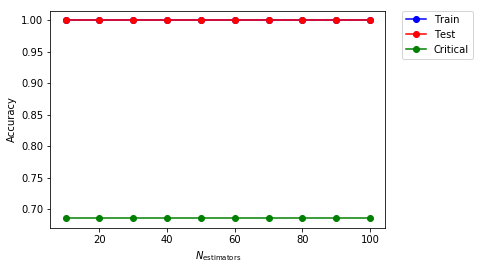

In [11]:
# We now plot our results

# plot accuracy against regularisation strength
plt.plot(n_estimators,ETC_train_accuracy[:,0],'o-b',label='Train')
plt.plot(n_estimators,ETC_test_accuracy[:,0],'o-r',label='Test')
plt.plot(n_estimators,ETC_critical_accuracy[:,0],'o-g',label='Critical')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()


### Exercises: ###  
<ul>

<li> [Random Forest] Consider $B$ random variables, each with variance $\sigma^2$. Show that **1)** If these random variables are i.i.d., then their average has a variance $\frac{1}{B}\sigma^2$. **2)** If they are only i.d. (i.e. identically distributed but not necessarily independent) with positive pairwise correlation $\rho$, then the variance of their average is  $\rho\sigma^2+\frac{1-\rho}{B}\sigma^2$. In this case, what does $B\gg 1$ imply? Justify that *by random selection of input features, random forest improves the variance reduction of bagging by reducing the correlation between the trees without dramatic increase of variance*.

<li> [Random Forest] Consider a random forest $G$ consisting of $K$ binary classification trees, $\{g_k| k=1,\cdots K\}$, where $K$ is an odd integer. Suppose each tree evaluates classification error based on binary counts (i.e. 0/1 error) with $E_{out}(g_k)=e_k$, prove or disprove that $\frac{2}{K+1}\sum_{k=1}^K e_k$ upper bounds $E_{out}(G)$.


<li> [OOB] For a data set with $N$ samples, what's the probability that one of samples, say $(\boldsymbol{x}_n,y_n)$, is never sampled after bootstrapping $N'$ times? Show that if $N'=N$ and $N\gg 1$, this probability is approximately $e^{-1}$. 

<li> [OOB] Following the previous question, if $N'=pN$ and assuming $N\gg 1$, argue that $Ne^{-p}$ examples in the data set will never be sampled at all.

<li> [OOB- programming] We argued that OOB is a good proxy for out-of-sample prediction due to bootstrapping. However, in practice OOB tends to give overly pessimistic estimate. To explore this, now instead of using OOB, try to cross-validation and redo all the analysis. You may find this tutorial [this tutorial](http://scikit-learn.org/stable/modules/cross_validation.html) on Scikit useful. 
</ul>